# Spikes

I build on the ideas developed by David [spikesandbursts](https://spikesandbursts.wordpress.com/about/):

> "I have utilized the function FindPeaks to analyze postsynaptic events (see [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/)), and here I show you a simplified version to detect action potentials. For a more detailed analysis of action potentials, I recommend using the packages IPFX or EFEL (tutorials [here](https://spikesandbursts.wordpress.com/2022/05/03/patch-clamp-analysis-python-action-potentials/)). If you have already done the spike analysis, skip this part."



We import a few libraries:

In [1]:
import numpy as np
import pandas as pd
 
import pyabf
 
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
 
import matplotlib.pyplot as plt

In [2]:
data_to_explore = []
data_to_explore.append(("lhb_bursting/cell21basal.abf",   5))
data_to_explore.append(("lhb_bursting/cell89basal.abf",  15))
data_to_explore.append(("lhb_bursting/cell91basal.abf",   4))
data_to_explore.append(("lhb_bursting/cell98basal.abf",   9))
data_to_explore.append(("lhb_bursting/cell104basal.abf", 10))
data_to_explore.append(("lhb_bursting/cell105basal.abf",  7))
data_to_explore.append(("lhb_bursting/cell107basal.abf",  0))
data_to_explore.append(("lhb_bursting/cell209basal.abf",  4))

We focus on specific cell, the cell # 89, and we ignore the sweep number for the moment:

In [56]:
file_path = data_to_explore[1][0]
print('path to the abf file : ',file_path)

path to the abf file :  lhb_bursting/cell89basal.abf


## Python libraries

## Load the data

In [20]:
# ABF files
data = file_path
abf = pyabf.ABF(data)
print(abf)

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


## Pre-process the signal: filtering

"I did not use it for this tutorial, but here is an example of how to filter the signal. More details can be found in this [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/#preprocessing-filtering)."

In [21]:
# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)
 
# Lowpass Bessel filter
b_lowpass, a_lowpass = signal.bessel(4,     # Order of the filter
                                     2000,  # Cutoff frequency
                                     'low', # Type of filter
                                     analog=False,  # Analog or digital filter
                                     norm='phase',  # Critical frequency normalization
                                     fs=fs)  # fs: sampling frequency
 
signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, abf.sweepY)

## Action potentials detection: FindPeaks

"I have utilized the function FindPeaks to analyze postsynaptic events (see [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/)), and here I show you a simplified version to detect action potentials. For a more detailed analysis of action potentials, I recommend using the packages IPFX or EFEL (tutorials [here](https://spikesandbursts.wordpress.com/2022/05/03/patch-clamp-analysis-python-action-potentials/)). If you have already done the spike analysis, skip this part."

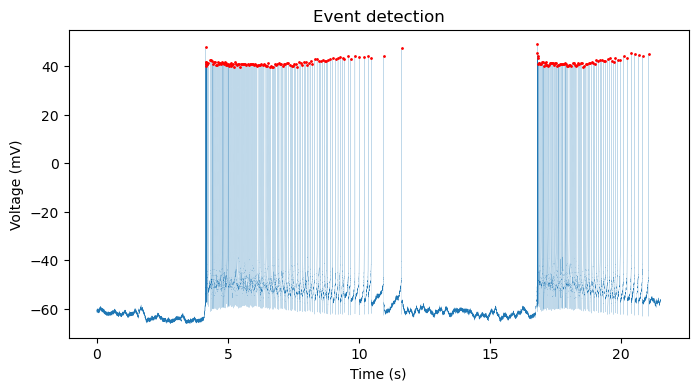

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,41492,4.1492,inf,0.0000,0.530190,0.099506,0.430684,47.752998,113.268997
1,2,41545,4.1545,188.679245,0.0053,0.535173,0.198077,0.337096,41.466999,100.508999
2,3,41605,4.1605,166.666667,0.0060,0.553585,0.194615,0.358971,40.966999,98.790001
3,4,41672,4.1672,149.253731,0.0067,0.578264,0.185913,0.392351,41.623001,100.822002
4,5,41757,4.1757,117.647059,0.0085,0.595801,0.204363,0.391437,40.028999,97.350998
...,...,...,...,...,...,...,...,...,...,...
196,197,203824,20.3824,6.531679,0.1531,0.618372,0.171005,0.447368,45.533001,108.327999
197,198,205210,20.5210,7.215007,0.1386,0.615512,0.185775,0.429737,45.063000,107.201000
198,199,206622,20.6622,7.082153,0.1412,0.627193,0.225217,0.401976,44.563000,107.357998
199,200,208157,20.8157,6.514658,0.1535,0.621055,0.147202,0.473853,44.000000,106.638000


In [22]:
# Assign the variables here to simplify the code
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered
abf.setSweep(15)

# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -25                    # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.5 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

## Export the table and the plot

Documentation: [save the figure](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html), and [table to csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).

In [23]:
fig.savefig('bursting/cell89basal.png', dpi=300)
spikes_table.to_csv('bursting/cell89basal_spike_table.csv', index=False)

## Interspike Intervals

Next, the histogram of interspike intervals (ISI) helps choose reliable threshold parameters in burst analysis. If you already have a table with the action potential results, load the ISIs data into the variable `hist_data`.

The code below will plot the histogram and calculate some distribution statistics. Additionally, I have simplified the cumulative moving average (Kapucu et al., 2012) to find peaks and valleys.
- Skewness quantifies distribution symmetry: 0 (symmetrical), positive (longer right tail), negative (longer left tail). Rule of thumb: skew > 1 or <-1 means significant.
- Kurtosis quantifies tail similarity to the Gaussian distribution: 0 (Gaussian), negative (fewer tail values than Gaussian), positive (more tail values).

Of course, the ISI distribution of the pyloric dilator neuron has an ideal bimodal distribution, while the ISI distribution is noisier in other cases. This makes threshold calculations challenging and beyond the scope of this tutorial. However, if you are interested, explore burst detection algorithms using ISI in [Pasquale et al., 2010](https://link.springer.com/article/10.1007/s10827-009-0175-1), [Kapucu et al., 2012](https://pmc.ncbi.nlm.nih.gov/articles/PMC3378047/), and [Bakkum et al., 2014](https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2013.00193/full).

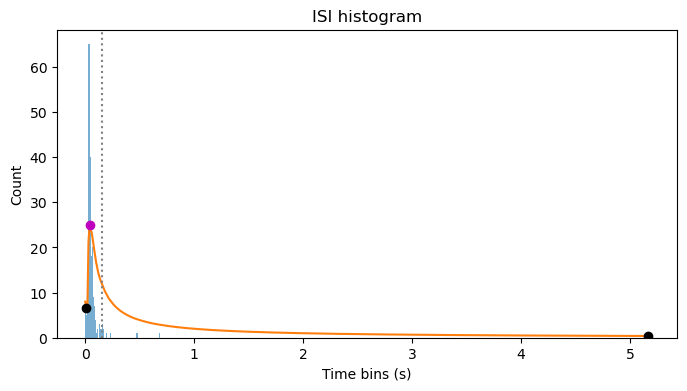

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.084071,0.0431,222.864529,14.087052,0.15,5.15,0.04


In [24]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

Let's do something simpler:

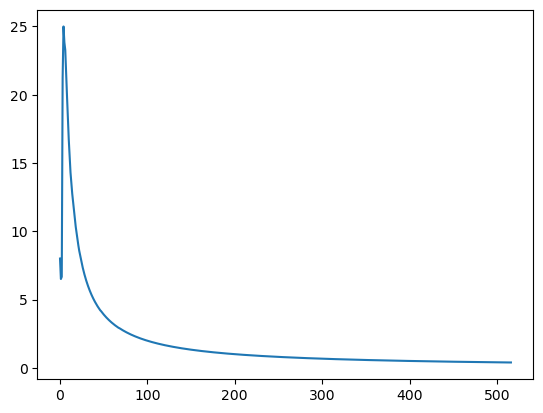

In [27]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)

plt.plot(cma)

---
# Burst detection

In [30]:
import pyabf
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

abf = pyabf.ABF(file_path)
abf.setSweep(15)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes using a threshold or peak detection
threshold = -20  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)

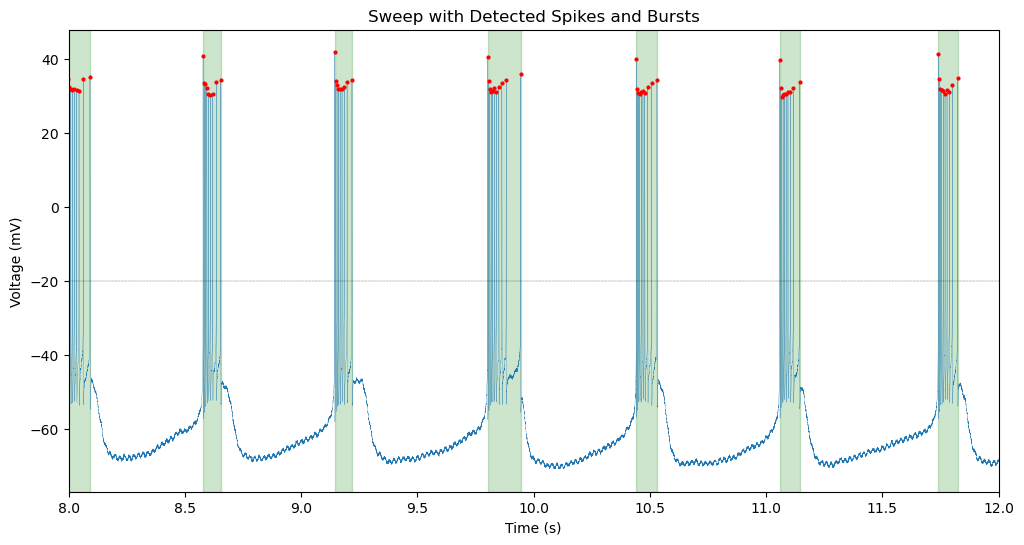

In [31]:
# Detect spikes
threshold = -20  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
plt.xlim((8,12))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

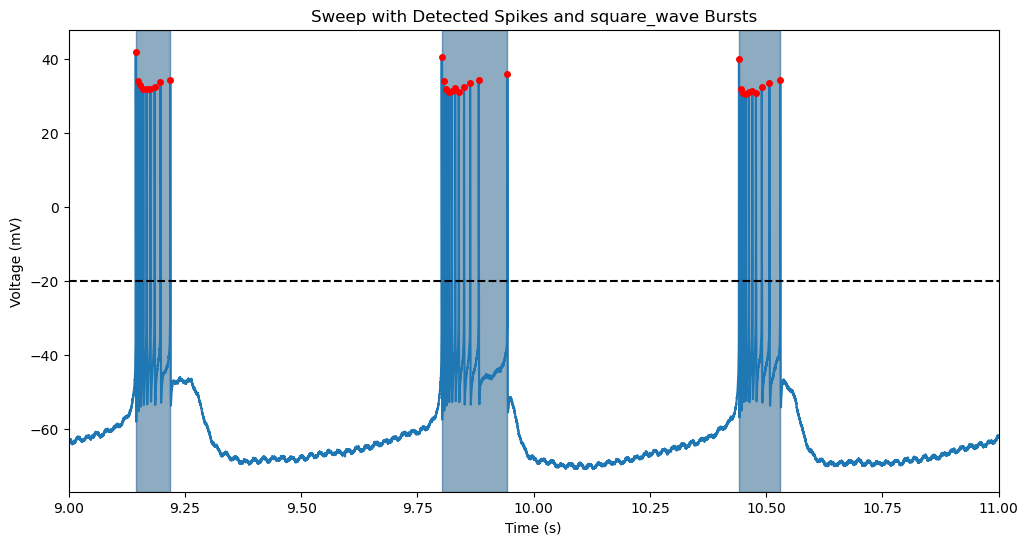

In [32]:
# Detect "square_wave" bursts
square_wave_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the mean voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.mean(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('-inf')  # No previous interval

    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('-inf')  # No next interval

    # Test if the burst is "square_wave"
    if burst_min_voltage > prev_mean_voltage and burst_min_voltage > next_mean_voltage:
        square_wave_bursts.append((burst_start, burst_end))

# Plot the sweep with square_wave bursts highlighted
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.3, label='Burst')

# Highlight square_wave bursts
for burst_start, burst_end in square_wave_bursts:
    plt.axvspan(burst_start, burst_end, color='blue', alpha=0.2, label='square_wave Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and square_wave Bursts")
#plt.legend()
plt.xlim((9,11))
plt.show()

# Print results
#for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
#    print(f"square_wave Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")


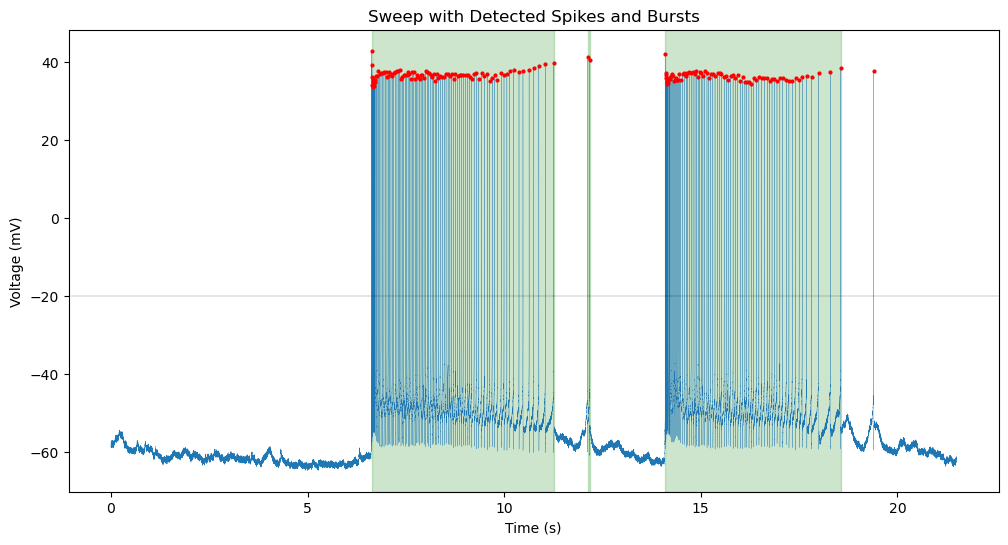

In [34]:
sweep_number = 9
abf = pyabf.ABF(file_path)
abf.setSweep(sweep_number)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes
threshold = -20  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
#plt.xlim((8,12))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

---
# Burst classification (very preliminary)

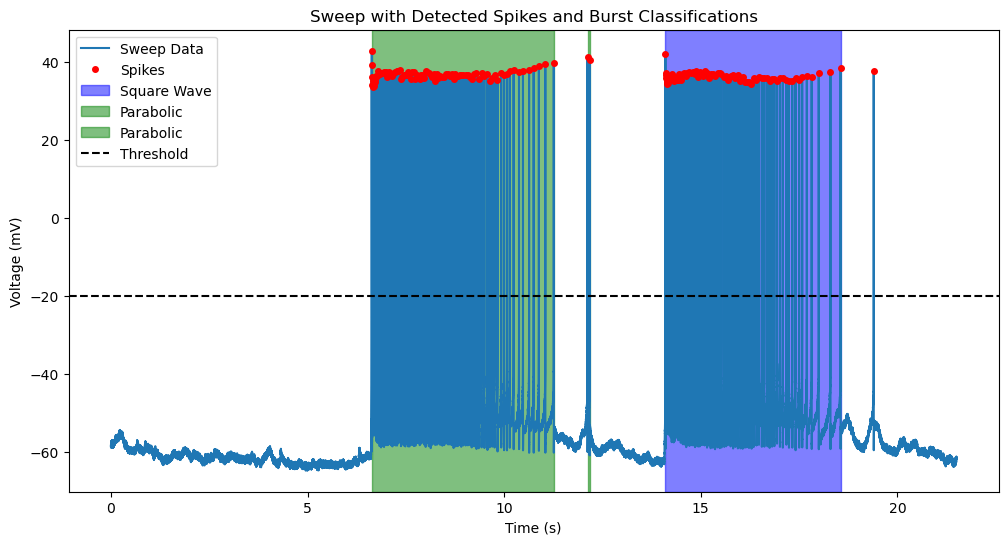

Square Wave Bursts:
  Burst 1: Start = 14.101 s, End = 18.554 s

Parabolic Bursts:
  Burst 1: Start = 6.633 s, End = 11.261 s
  Burst 2: Start = 12.119 s, End = 12.174 s

Other Bursts:


In [35]:
# Initialize lists for categorized bursts
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the minimum voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.min(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison

    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('nan')  # No next interval, ignore in comparison

    # Calculate overall inter-burst mean voltage
    inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

    # Test conditions to classify the burst
    if burst_min_voltage > inter_burst_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min_voltage < inter_burst_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# Plot the sweep with classified bursts highlighted
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts
for burst_start, burst_end in square_wave_bursts:
    plt.axvspan(burst_start, burst_end, color='blue', alpha=0.5, label='Square Wave')

for burst_start, burst_end in parabolic_bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.5, label='Parabolic')

for burst_start, burst_end in other_bursts:
    plt.axvspan(burst_start, burst_end, color='orange', alpha=0.5, label='Other')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Burst Classifications")
plt.legend()
plt.show()

# Print results
print("Square Wave Bursts:")
for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nParabolic Bursts:")
for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nOther Bursts:")
for i, (burst_start, burst_end) in enumerate(other_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")


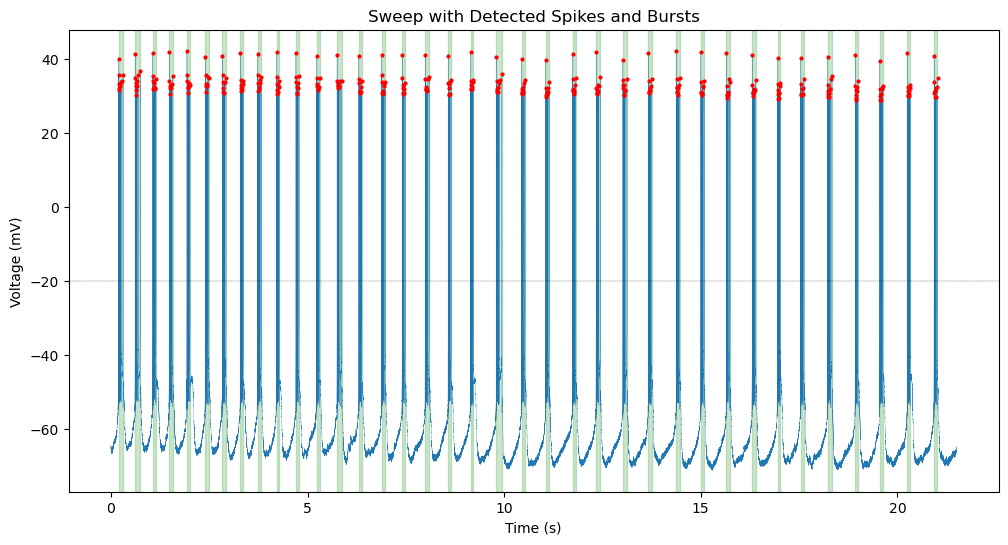

In [37]:
sweep_number = 15
abf = pyabf.ABF(file_path)
abf.setSweep(sweep_number)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes
threshold = -20  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
#plt.xlim((8,12))
#plt.legend()
plt.show()


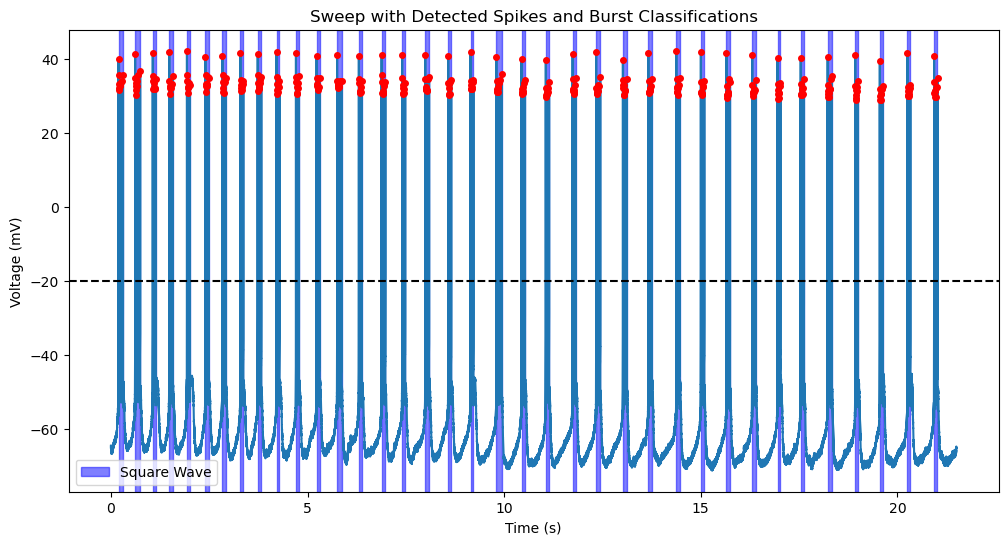

Square Wave Bursts:
  Burst 1: Start = 0.193 s, End = 0.307 s
  Burst 2: Start = 0.615 s, End = 0.744 s
  Burst 3: Start = 1.064 s, End = 1.145 s
  Burst 4: Start = 1.484 s, End = 1.574 s
  Burst 5: Start = 1.933 s, End = 2.010 s
  Burst 6: Start = 2.403 s, End = 2.491 s
  Burst 7: Start = 2.836 s, End = 2.925 s
  Burst 8: Start = 3.293 s, End = 3.367 s
  Burst 9: Start = 3.733 s, End = 3.824 s
  Burst 10: Start = 4.211 s, End = 4.286 s
  Burst 11: Start = 4.705 s, End = 4.783 s
  Burst 12: Start = 5.229 s, End = 5.306 s
  Burst 13: Start = 5.751 s, End = 5.869 s
  Burst 14: Start = 6.304 s, End = 6.382 s
  Burst 15: Start = 6.883 s, End = 6.979 s
  Burst 16: Start = 7.406 s, End = 7.483 s
  Burst 17: Start = 7.993 s, End = 8.092 s
  Burst 18: Start = 8.578 s, End = 8.654 s
  Burst 19: Start = 9.144 s, End = 9.219 s
  Burst 20: Start = 9.802 s, End = 9.944 s
  Burst 21: Start = 10.442 s, End = 10.530 s
  Burst 22: Start = 11.059 s, End = 11.144 s
  Burst 23: Start = 11.740 s, End = 11.

In [38]:
# Initialize lists for categorized bursts
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the minimum voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.min(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison

    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('nan')  # No next interval, ignore in comparison

    # Calculate overall inter-burst mean voltage
    inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

    # Test conditions to classify the burst
    if burst_min_voltage > inter_burst_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min_voltage < inter_burst_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# Plot the sweep with classified bursts highlighted
plt.figure(figsize=(12, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts with a single legend entry per category
square_wave_patch = None
parabolic_patch = None
other_patch = None

for burst_start, burst_end in square_wave_bursts:
    square_wave_patch = plt.axvspan(burst_start, burst_end, color='blue', alpha=0.5, label='Square Wave')

for burst_start, burst_end in parabolic_bursts:
    parabolic_patch = plt.axvspan(burst_start, burst_end, color='green', alpha=0.5, label='Parabolic')

for burst_start, burst_end in other_bursts:
    other_patch = plt.axvspan(burst_start, burst_end, color='orange', alpha=0.5, label='Other')

# Filter out None handles
handles = [patch for patch in [square_wave_patch, parabolic_patch, other_patch] if patch is not None]
labels = ['Square Wave', 'Parabolic', 'Other'][:len(handles)]

# Add a single legend entry for each classification
plt.legend(handles, labels)

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Burst Classifications")
plt.show()

# Print results
print("Square Wave Bursts:")
for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nParabolic Bursts:")
for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nOther Bursts:")
for i, (burst_start, burst_end) in enumerate(other_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")


In [39]:
def analyze_spikes_and_bursts(file_path, sweep_number, xmin=None, xmax=None, voltage_threshold =None, burst_threshold=None):
    # Load the data
    abf = pyabf.ABF(file_path)
    abf.setSweep(sweep_number)
    time = abf.sweepX
    voltage = abf.sweepY
    
    # ---------------------------------------------------------------------------
    # --- Detect spikes ---------------------------------------------------------
    # ---------------------------------------------------------------------------

    spike_indices, _ = find_peaks(voltage, height=voltage_threshold)
    spike_times = time[spike_indices]  # Convert spike indices to times

    # Detect bursts based on ISI
    isi = np.diff(spike_times)  # Inter-spike intervals

    # ---------------------------------------------------------------------------
    # --- Identify bursts
    # ---------------------------------------------------------------------------

    bursts = []
    current_burst = [spike_times[0]]  # Initialize the 1st burst with the 1st spike
    for i in range(1, len(isi)):
        if isi[i - 1] < burst_threshold:  # Continue the burst
            current_burst.append(spike_times[i])
        else:  # End the current burst and start a new one
            if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
                bursts.append((current_burst[0], current_burst[-1]))
            current_burst = [spike_times[i]]
    # Add the last burst if valid
    if len(current_burst) > 1:
        bursts.append((current_burst[0], current_burst[-1]))

    # ---------------------------------------------------------------------------
    # classify bursts
    # ---------------------------------------------------------------------------

    square_wave_bursts = []
    parabolic_bursts = []
    other_bursts = []

    for i, (burst_start, burst_end) in enumerate(bursts):
        # Calculate the minimum voltage during the burst
        burst_mask = (time >= burst_start) & (time <= burst_end)
        burst_min_voltage = np.min(voltage[burst_mask])

        # Calculate mean voltage during the preceding inter-burst interval
        if i > 0:  # Check if there's a previous burst
            prev_end = bursts[i - 1][1]
            inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
            prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
        else:
            prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison

        # Calculate mean voltage during the succeeding inter-burst interval
        if i < len(bursts) - 1:  # Check if there's a next burst
            next_start = bursts[i + 1][0]
            inter_burst_next_mask = (time > burst_end) & (time < next_start)
            next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
        else:
            next_mean_voltage = float('nan')  # No next interval, ignore in comparison

        # Calculate overall inter-burst mean voltage
        inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

        # Test conditions to classify the burst
        if burst_min_voltage > inter_burst_mean:
            square_wave_bursts.append((burst_start, burst_end))
        elif burst_min_voltage < inter_burst_mean:
            parabolic_bursts.append((burst_start, burst_end))
        else:
            other_bursts.append((burst_start, burst_end))

    # ---------------------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------------------

    # --- Plot the sweep with classified bursts highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(time, voltage, label='Sweep Data',lw=0.2)
    plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

    # Highlight bursts
    for burst_start, burst_end in square_wave_bursts:
        plt.axvspan(burst_start, burst_end, color='blue', alpha=0.1, label='Square Wave')

    for burst_start, burst_end in parabolic_bursts:
        plt.axvspan(burst_start, burst_end, color='green', alpha=0.1, label='Parabolic')

    for burst_start, burst_end in other_bursts:
        plt.axvspan(burst_start, burst_end, color='orange', alpha=0.1, label='Other')


    # Highlight bursts and prepare legend handles
    square_wave_patch = None
    parabolic_patch = None
    other_patch = None

    for burst_start, burst_end in square_wave_bursts:
        square_wave_patch = plt.axvspan(burst_start, burst_end, color='blue', alpha=0.1, label='Square Wave')

    for burst_start, burst_end in parabolic_bursts:
        parabolic_patch = plt.axvspan(burst_start, burst_end, color='green', alpha=0.1, label='Parabolic')

    for burst_start, burst_end in other_bursts:
        other_patch = plt.axvspan(burst_start, burst_end, color='orange', alpha=0.1, label='Other')

    # Filter handles to include only non-None entries
    handles = []
    labels = []
    if square_wave_patch:
        handles.append(square_wave_patch)
        labels.append("Square Wave")
    if parabolic_patch:
        handles.append(parabolic_patch)
        labels.append("Parabolic")
    if other_patch:
        handles.append(other_patch)
        labels.append("Other")

    

    #plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.title("Sweep with Detected Spikes and Burst Classifications")
    plt.legend(handles, labels)
    plt.xlim((xmin,xmax))
    plt.show()

    # Print results
 #   print("Square Wave Bursts:")
 #   for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
 #      print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

 #   print("\nParabolic Bursts:")
 #   for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
 #       print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

 #   print("\nOther Bursts:")
 #   for i, (burst_start, burst_end) in enumerate(other_bursts):
 #       print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")
# Example usage
# analyze_spikes_and_bursts("path_to_abf_file.abf", 15, xmin=0, xmax=10, burst_threshold=50)

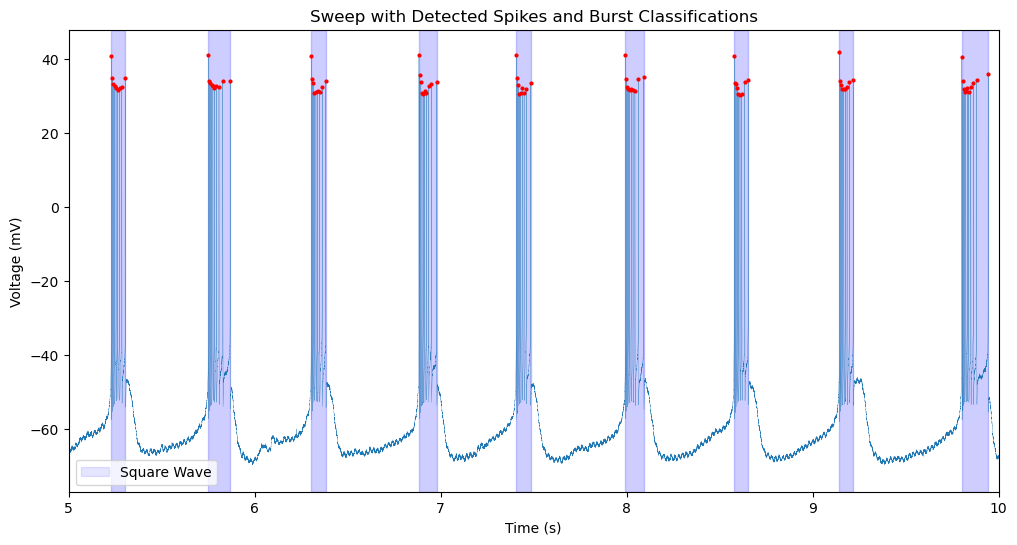

In [40]:
sweep_number = 15
analyze_spikes_and_bursts(file_path, sweep_number, xmin=5, xmax=10, voltage_threshold = -20, burst_threshold=0.3)

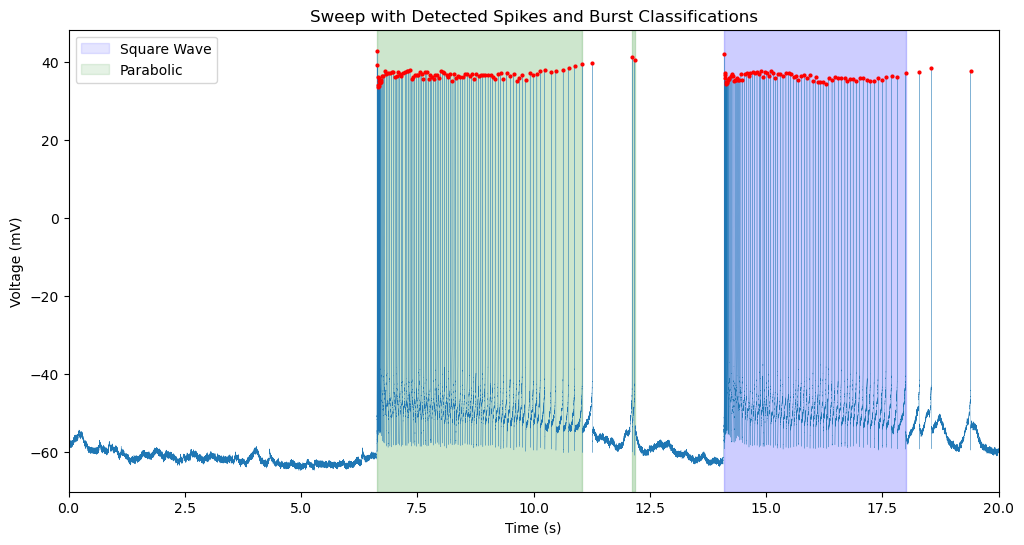

In [41]:
sweep_number = 9
analyze_spikes_and_bursts(file_path, sweep_number, xmin=0, xmax=20, voltage_threshold = -20, burst_threshold=0.2)

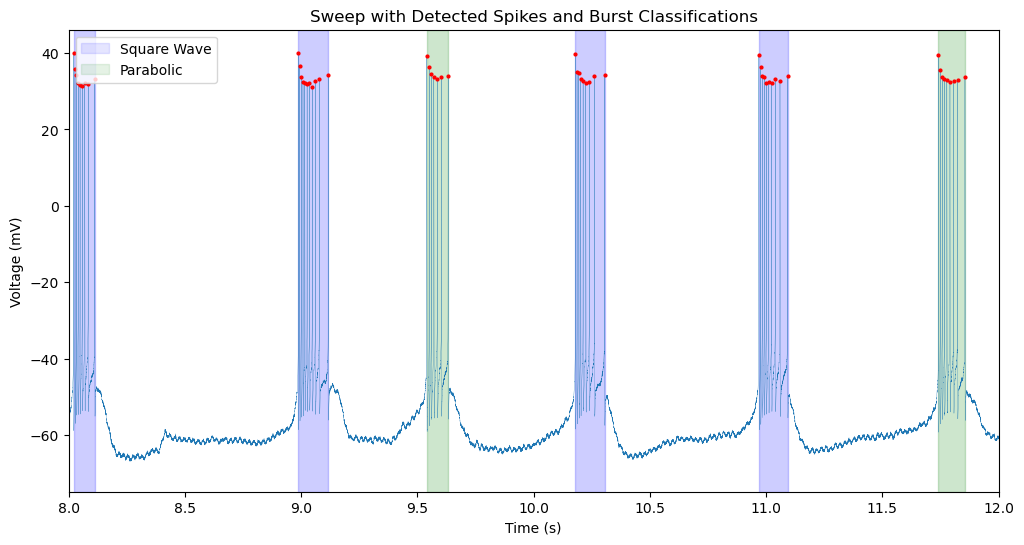

In [42]:
sweep_number = 17
analyze_spikes_and_bursts(file_path, sweep_number, xmin=8, xmax=12, voltage_threshold = -20, burst_threshold=0.1)